In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("src/vsa.jl")

unbind (generic function with 2 methods)

In [3]:
using Plots

In [4]:
n_x = 101
n_y = 101
n_vsa = 1

1

In [5]:
repeats = 6

6

In [6]:
phase_x = reshape(range(-1.0, 1.0, n_x), (1, n_x, n_vsa)) |> collect
phase_y = reshape(range(-1.0, 1.0, n_y), (1, n_y, n_vsa)) |> collect

1×101×1 Array{Float64, 3}:
[:, :, 1] =
 -1.0  -0.98  -0.96  -0.94  -0.92  -0.9  …  0.9  0.92  0.94  0.96  0.98  1.0

In [7]:
sims = similarity_outer(phase_x, phase_y, dims= 2, reduce_dim=1)[1,1,:,:]

101×101 Matrix{Float64}:
 1.0       0.998027  0.992115  0.982287  …  0.992115  0.998027  1.0
 0.998027  1.0       0.998027  0.992115     0.982287  0.992115  0.998027
 0.992115  0.998027  1.0       0.998027     0.968583  0.982287  0.992115
 0.982287  0.992115  0.998027  1.0          0.951057  0.968583  0.982287
 0.968583  0.982287  0.992115  0.998027     0.929776  0.951057  0.968583
 0.951057  0.968583  0.982287  0.992115  …  0.904827  0.929776  0.951057
 0.929776  0.951057  0.968583  0.982287     0.876307  0.904827  0.929776
 0.904827  0.929776  0.951057  0.968583     0.844328  0.876307  0.904827
 0.876307  0.904827  0.929776  0.951057     0.809017  0.844328  0.876307
 0.844328  0.876307  0.904827  0.929776     0.770513  0.809017  0.844328
 0.809017  0.844328  0.876307  0.904827  …  0.728969  0.770513  0.809017
 0.770513  0.809017  0.844328  0.876307     0.684547  0.728969  0.770513
 0.728969  0.770513  0.809017  0.844328     0.637424  0.684547  0.728969
 ⋮                             

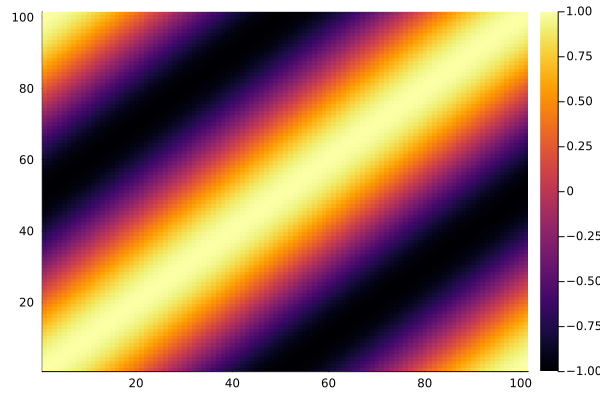

In [8]:
heatmap(sims)

In [9]:
spk_args = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [10]:
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [11]:
st_x = phase_to_train(phase_x, spk_args, repeats = repeats)
st_y = phase_to_train(phase_y, spk_args, repeats = repeats)

Spike Train: (1, 101, 1) with 606 spikes.

In [12]:
sims_2 = similarity_outer(st_x, st_y, dims=2, reduce_dim=3, tspan=tspan);

In [13]:
sims_2

101×101 Matrix{Array{Float64, 3}}:
 [-1.0;;; 1.0;;; 1.0;;; … ;;; 1.0;;; 1.0;;; 1.0]                       …  [-1.0;;; -0.5;;; -0.5;;; … ;;; 0.999999;;; 0.999998;;; 0.999998]
 [-1.0;;; -0.5;;; 0.998024;;; … ;;; 0.997724;;; 0.997724;;; 0.997724]     [-1.0;;; -1.0;;; -0.5;;; … ;;; 0.997603;;; 0.997603;;; 0.997588]
 [-1.0;;; -0.5;;; -0.5;;; … ;;; 0.992104;;; 0.992104;;; 0.992104]         [-1.0;;; -1.0;;; -1.0;;; … ;;; 0.991881;;; 0.991881;;; 0.991853]
 [-1.0;;; -0.5;;; -0.5;;; … ;;; 0.969322;;; 0.969322;;; 0.969322]         [-1.0;;; -1.0;;; -1.0;;; … ;;; 0.968885;;; 0.968885;;; 0.96883]
 [-1.0;;; -0.5;;; -0.5;;; … ;;; 0.967405;;; 0.967405;;; 0.967405]         [-1.0;;; -1.0;;; -1.0;;; … ;;; 0.966955;;; 0.966955;;; 0.966899]
 [-1.0;;; -0.5;;; -0.5;;; … ;;; 0.949583;;; 0.949582;;; 0.949583]      …  [-1.0;;; -1.0;;; -1.0;;; … ;;; 0.949026;;; 0.949025;;; 0.948957]
 [-1.0;;; -0.5;;; -0.5;;; … ;;; 0.920845;;; 0.920845;;; 0.920845]         [-1.0;;; -1.0;;; -1.0;;; … ;;; 0.920153;;; 0.920153;;; 0.9

In [14]:
size(sims_2)

(101, 101)

In [15]:
sims_3 = stack(sims_2);

In [16]:
size(sims_3)

(1, 1, 601, 101, 101)

In [17]:
avg_error = mean(sims_3[1,1,:,:,:] .- reshape(sims, (1, 101, 101)), dims=(2,3));

In [18]:
avg_error |> size

(601, 1, 1)

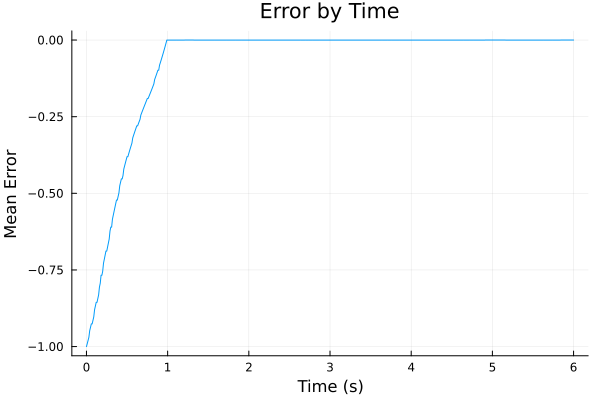

In [19]:
error_time = plot(0:0.01:6.0, avg_error |> vec, label=missing)
xlabel!("Time (s)")
ylabel!("Mean Error")
title!("Error by Time")

In [20]:
png(error_time, "sim time error.png")

"sim time error.png"

In [21]:
error_by_time = [sims]

1-element Vector{Matrix{Float64}}:
 [1.0 0.9980267284282716 … 0.9980267284282716 1.0; 0.9980267284282716 1.0 … 0.9921147013144778 0.9980267284282716; … ; 0.9980267284282716 0.9921147013144778 … 1.0 0.9980267284282716; 1.0 0.9980267284282716 … 0.9980267284282716 1.0]

In [22]:
sims_2[1,1]

1×1×601 Array{Float64, 3}:
[:, :, 1] =
 -1.0

[:, :, 2] =
 1.0

[:, :, 3] =
 0.999999761581428

;;; … 

[:, :, 599] =
 1.0

[:, :, 600] =
 0.999999761581428

[:, :, 601] =
 1.0

In [23]:
ds = [s[1,1,end] for s in sims_2]

101×101 Matrix{Float64}:
 1.0       0.997724  0.992104  0.969322  …  0.995368  0.99983   0.999998
 0.997724  1.0       0.998303  0.98369      0.986619  0.996312  0.997588
 0.992104  0.998303  1.0       0.992495     0.975451  0.989625  0.991853
 0.969322  0.98369   0.992495  1.0          0.9412    0.964628  0.96883
 0.967405  0.982279  0.991526  0.99997      0.938577  0.962575  0.966899
 0.949583  0.968563  0.981405  0.997512  …  0.915041  0.943645  0.948957
 0.920845  0.945043  0.962478  0.988438     0.879091  0.913505  0.920067
 0.882024  0.91179   0.934156  0.970785     0.832634  0.873192  0.881083
 0.855785  0.888722  0.913909  0.956688     0.802082  0.846107  0.854753
 0.83277   0.868206  0.895627  0.943299     0.775685  0.822428  0.831666
 0.787854  0.827591  0.858872  0.91506   …  0.724994  0.776373  0.786627
 0.745929  0.789143  0.823569  0.886751     0.678439  0.73353   0.744601
 0.683021  0.730719  0.769232  0.841596     0.609635  0.669448  0.681566
 ⋮                         

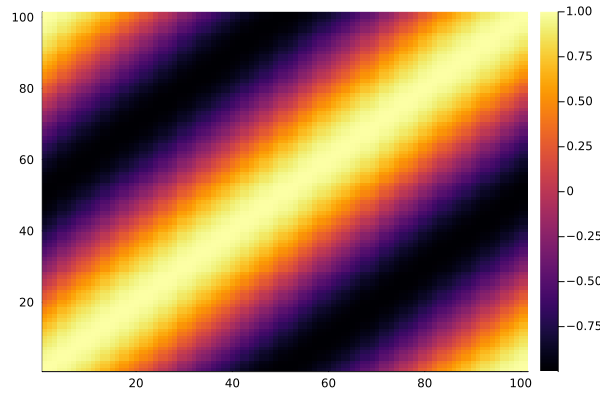

In [24]:
heatmap(ds)

In [25]:
using StatsPlots: density

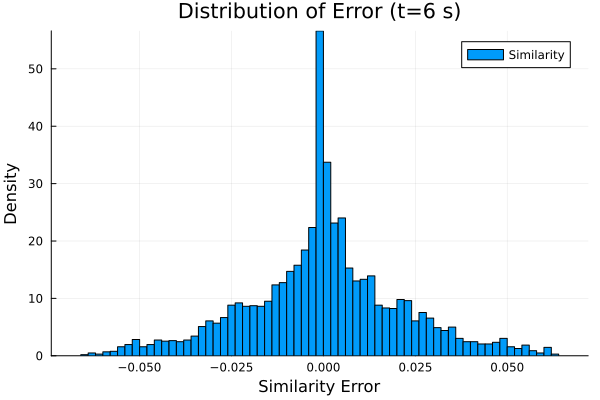

In [26]:
fig = histogram((vec(ds .- sims)), label="Similarity", normalize=:pdf)
xlabel!("Similarity Error")
ylabel!("Density")
title!("Distribution of Error (t=6 s)")

In [27]:
png(fig, "sim phase error.png")

"sim phase error.png"

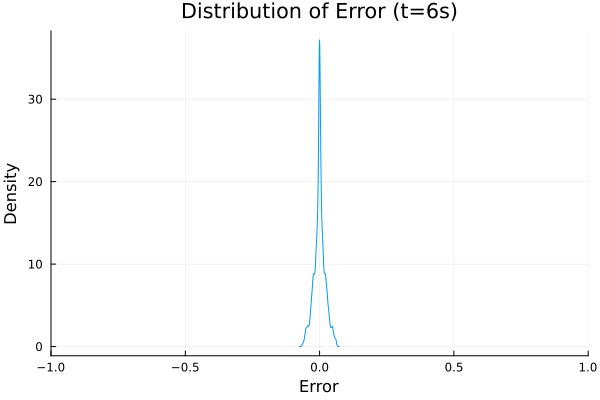

In [28]:
error_dist = density((vec(ds .- sims)), label=missing, xlims=(-1, 1))
xlabel!("Error")
ylabel!("Density")
title!("Distribution of Error (t=6s)")

In [29]:
png(error_dist, "sim error density.png")

"sim error density.png"

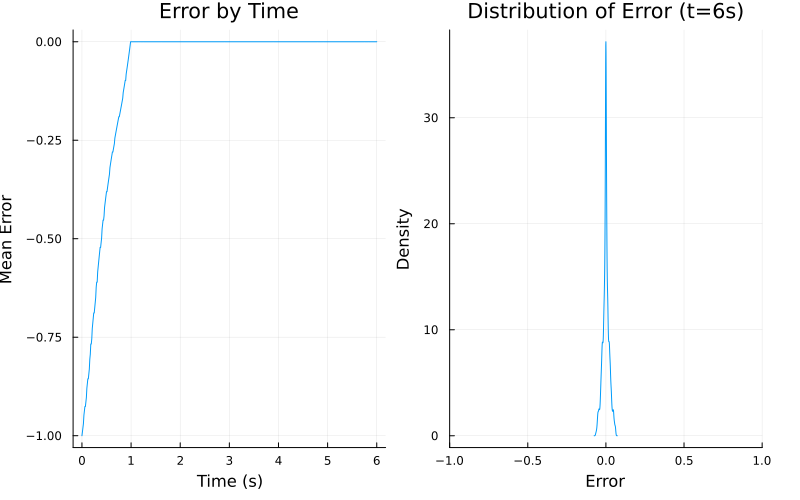

In [30]:
l = @layout[a{0.48w, 0.98h} b{0.48w, 0.98h}]
fig = plot(error_time, error_dist, layout = l, size=(800, 500))

In [31]:
png(fig, "similarity joint plot.png")

"similarity joint plot.png"